#  Final Project
## Zillow Home Sell Price Predictions
### Cody Hoffman


---

## Intro
I will be running an analysis on the housing market within Seattle proper. The goal is to find 5 neighborhoods with predictable
and promising growth.

In [31]:
reset -fs

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

%config InlineBackend.figure_format = 'svg'

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


## EDA

In [33]:
df = pd.read_csv(r"C:\Users\Grimmethy\Downloads\zillow_data.csv")

In [34]:
## The original data was in wide format. 
## In order to process our algorithms I used the melt function to transform it into long format.
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 'RegionID', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [35]:
## I save the long formatted data as df_main
df_main = melt_data(df)

In [36]:
## I plan to use a single Seattle zip code "Columbia City" to train the algorithm.
df_cc = df_main[df_main["RegionName"] == 98118]

In [37]:
## I use the sellprice variable to store only the relevant information needed for creating the model 
## without damaging the original dataframe.
sellprice = df_cc['value']
sellprice.index = pd.DatetimeIndex(df_cc['time'])

In [38]:
## There were no NA values in the chosen zip code however this variable will ensure one doesn't sneak past us. 
sellprice_not_na = sellprice[~sellprice.isna()]

### Read, visualize raw data

In [39]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#### Line, ACF plots

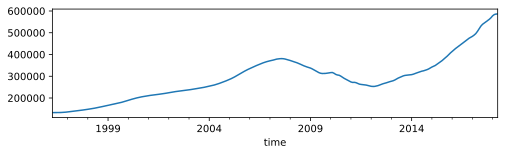

In [40]:
plt.figure(figsize=(8, 2))
sellprice.plot()
# plt.xticks(rotation=45)
plt.show()

### Differencing

#### 1-time trend differencing

In [42]:
## The data has some very deep long term trends. Differencing absolutely needs to be set up to try and get a more stationary set.
sellprice_d1 = pd.Series(np.diff(sellprice_not_na.values, n=1),
                           index=sellprice_not_na.index[1:])

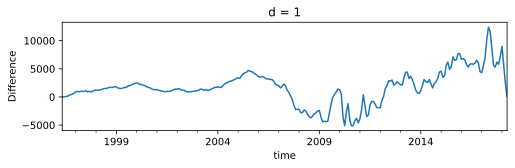

In [43]:
plt.figure(figsize=(8, 2))
sellprice_d1.plot()
plt.ylabel('Difference')
plt.title('d = 1')
plt.show()

In [44]:
adf_test(sellprice_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.948085
p-value                          0.309789
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


#### 2-time trend differencing

In [45]:
## This model seems more stationary at first however when run through the sarima model it creates a wildly ineffective prediction.
sellprice_d2 = pd.Series(np.diff(sellprice_not_na.values, n=2),
                           index=sellprice_not_na.index[2:])

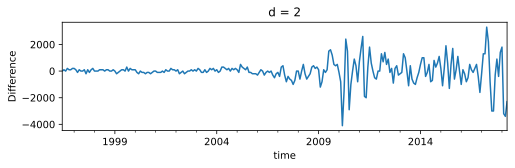

In [46]:
plt.figure(figsize=(8, 2))
sellprice_d2.plot()
plt.ylabel('Difference')
plt.title('d = 2')
plt.show()

In [47]:
adf_test(sellprice_d2)

Results of Dickey-Fuller Test:
Test Statistic                  -3.791637
p-value                          0.002994
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


#### 3-time trend differencing

In [48]:
sellprice_d3 = pd.Series(np.diff(sellprice_not_na.values, n=3),
                           index=sellprice_not_na.index[3:])

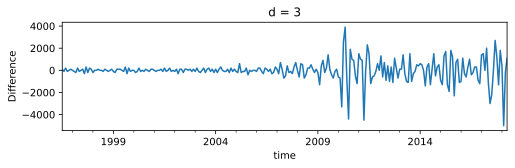

In [49]:
plt.figure(figsize=(8, 2))
sellprice_d3.plot()
plt.ylabel('Difference')
plt.title('d = 3')
plt.show()

In [50]:
adf_test(sellprice_d3)

Results of Dickey-Fuller Test:
Test Statistic                -7.478539e+00
p-value                        4.840796e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


#### 1-time seasonal differencing on 2-time trend differencing

There appears to be slight seasonality with lag 12, according to the 1-time differencing line plot.

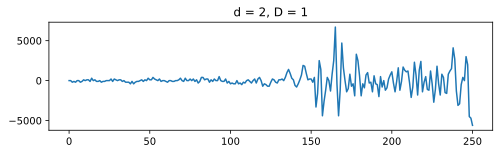

In [51]:
## With real estate seasonality can be expected. Here we set lags to help account for it.
## The 1x differencing creates a prediction well under the validation mark.
sellprice_d2_D1 = []
for i in range(12, len(sellprice_d2)):
    value = sellprice_d2[i] - sellprice_d2[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D1.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 1')
plt.plot(sellprice_d2_D1) 
plt.show()

In [52]:
adf_test(sellprice_d2_D1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.548848
p-value                          0.000160
#Lags Used                      14.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


#### 2-time seasonal differencing on 2-time trend differencing

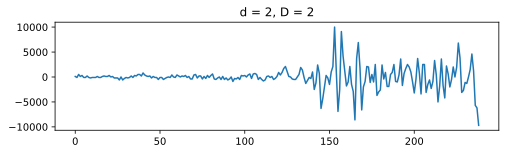

In [53]:
## For the chosen zip code 2x differencing brings the validation forecast very close in line with the original data.
sellprice_d2_D2 = []
for i in range(12, len(sellprice_d2_D1)):
    value = sellprice_d2_D1[i] - sellprice_d2_D1[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D2.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 2')
plt.plot(sellprice_d2_D2) 
plt.show()

In [54]:
adf_test(sellprice_d2_D2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.104082
p-value                          0.000014
#Lags Used                      14.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


---

## Best SARIMA-class model

### d = 1, D = 2

In [180]:
## After testing multpile differencing sets this came out to be the most accurate.
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = pd.date_range(start = '2018-05-01', end = '2019-04-01', freq = 'MS')

In [181]:
model_d1_D2 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=2, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.67 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.41 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.96 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.38 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.73 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.68 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.41 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.36 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.45 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=3492.4

In [182]:
model_d1_D2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(2, 2, [], 12)   Log Likelihood               -1722.799
Date:                             Thu, 12 Nov 2020   AIC                           3455.598
Time:                                     07:51:29   BIC                           3471.753
Sample:                                          0   HQIC                          3462.144
                                             - 212                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8063      0.037     21.812      0.000       0.734       0.879
ma.L1         -0.5299      0.039    -13.563      0.000      -0.606      -0.453
ar.S.L12      -0.3802      0.010    -36.463      0.000      -0.401      -0.360
ar.S.L24      -0.1591      0.005    -33.224      0.000      -0.168      -0.150
sigma2      4.795e+06   1.75e-09   2.74e+15      0.000     4.8e+06     4.8e+06
===================================================================================
Ljung-Box (Q):                      108.07   Jarque-Bera (JB):               377.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.56
Prob(H) (two-sided):                  0.37   Kurtosis:                         9.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.69e+30. Standard errors may be unstable.
"""

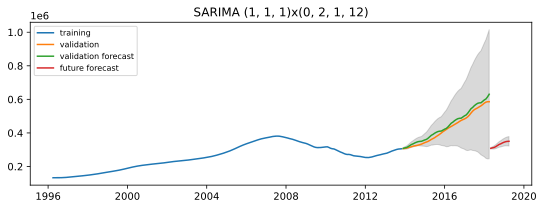

In [183]:
## As we can see, for this zip code the predictions match up very nicely.
fc1, conf1 = model_d1_D2.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d1_D2.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test)
upper_series2 = pd.Series(conf2[:, 1], index=test)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (1, 1, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [80]:
mse = ((fc_series1 - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

19735.06


### SARIMA (1, 1, 1) x (0, 2, 1, 12) Forecasting

In [81]:
train = sellprice_not_na
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [82]:
model_d1_D2_all = pm.auto_arima(train, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                start_P=0, seasonal=True,
                                d=1, D=2, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=4597.418, Time=0.08 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=4529.270, Time=1.96 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=4555.634, Time=0.45 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=4468.499, Time=2.30 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=3.48 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=4560.040, Time=0.97 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=4457.807, Time=6.63 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=4520.947, Time=2.89 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=9.19 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.66 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=4485.594, Time=3.65 sec
 ARIMA(2,1,1)(2,2,0)[12]             : AIC=4482.6

In [83]:
model_d1_D2_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 2, [], 12)   Log Likelihood               -2223.112
Date:                             Thu, 12 Nov 2020   AIC                           4456.224
Time:                                     06:36:18   BIC                           4473.627
Sample:                                          0   HQIC                          4463.236
                                             - 265                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7393      0.057     12.893      0.000       0.627       0.852
ma.L1         -0.2875      0.057     -5.015      0.000      -0.400      -0.175
ar.S.L12      -0.4793      0.008    -58.726      0.000      -0.495      -0.463
ar.S.L24      -0.1969      0.004    -48.543      0.000      -0.205      -0.189
sigma2       5.44e+06   4.31e-09   1.26e+15      0.000    5.44e+06    5.44e+06
===================================================================================
Ljung-Box (Q):                       59.95   Jarque-Bera (JB):              1356.99
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.36
Prob(H) (two-sided):                  0.13   Kurtosis:                        14.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.1e+30. Standard errors may be unstable.
"""

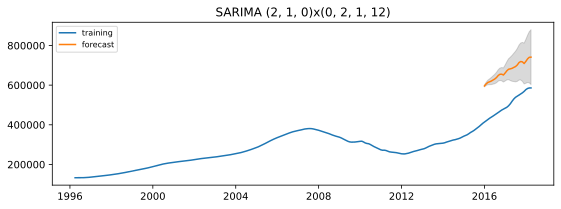

In [84]:
fc, conf = model_d1_D2_all.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)

lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('SARIMA (2, 1, 0)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Best SARIMA Log-Transformed Model

## Model selection with Auto-ARIMA

In [85]:
def create_training_splits(data, log=False):
    
    train_size = int(len(data) * 0.8)
    
    train = data[:train_size]
    valid = data[train_size:]
    
    # Hardcoded
    test = sellprice[sellprice.index >= pd.to_datetime('2016')] 
    
    if log: 
        return np.log(train), np.log(valid), np.log(test)
    else: 
        return train, valid, test

In [86]:
train, valid, test = create_training_splits(sellprice_not_na)

In [87]:
logtrain, logvalid, logtest = create_training_splits(sellprice_not_na, log=True)

In [88]:
fulldata = sellprice_not_na

In [89]:
logfull = np.log(fulldata)

### d = 1, D = 1

In [93]:
log_model_d1_D1 = pm.auto_arima(logtrain, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                start_P=0, seasonal=True,
                                d=1, D=1, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-1749.031, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1387.207, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1753.192, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-1573.281, Time=0.92 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1688.879, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1762.758, Time=2.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-1767.566, Time=2.37 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-1768.148, Time=1.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-1717.973, Time=0.14 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-1772.317, Time=2.25 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-1785.812, Time=2.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-1399.765, Time=3.69 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=-1762.681, Time=1.58 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-1773.090, Time=2.16 sec
 ARIM

In [94]:
log_model_d1_D1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  212
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 911.349
Date:                            Thu, 12 Nov 2020   AIC                          -1810.697
Time:                                    06:39:37   BIC                          -1790.937
Sample:                                         0   HQIC                         -1802.700
                                            - 212                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.679e-05      0.000     -0.314      0.753      -0.000       0.000
ar.L1          0.3650      0.084      4.347      0.000       0.200       0.530
ar.L2          0.4876      0.078      6.231      0.000       0.334       0.641
ma.L1          0.8111      0.064     12.601      0.000       0.685       0.937
ma.S.L12      -0.7197      0.044    -16.299      0.000      -0.806      -0.633
sigma2      5.816e-06   3.53e-07     16.489      0.000    5.12e-06    6.51e-06
===================================================================================
Ljung-Box (Q):                      143.74   Jarque-Bera (JB):               555.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.62   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

NameError: name 'params_temp' is not defined

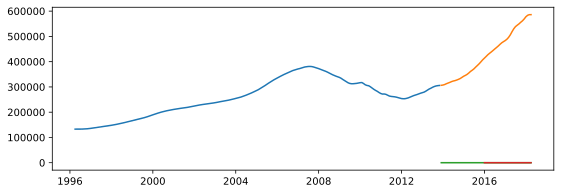

In [119]:
fc1, conf1 = log_model_d1_D1.predict(len(logvalid), return_conf_int=True, alpha=0.05)
fc2, conf2 = log_model_d1_D1.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=logvalid.index)
fc_series2 = pd.Series(fc2, index=logtest.index)

lower_series1 = pd.Series(conf1[:, 0], index=logvalid.index)
upper_series1 = pd.Series(conf1[:, 1], index=logvalid.index)
lower_series2 = pd.Series(conf2[:, 0], index=logtest.index)
upper_series2 = pd.Series(conf2[:, 1], index=logtest.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title(f'SARIMA {params_temp["order"]}x{params_temp["seasonal_order"]} ' + str(98118))
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [120]:
mse = ((fc_series1 - logvalid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

0.32


#### Transformed Back

In [121]:
mse = ((np.exp(fc_series1) - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

134343.62


### Training Model on Full Data

In [122]:
log_model_d1_D1_full = pm.auto_arima(logfull, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-2222.942, Time=0.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1764.417, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2138.536, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2002.534, Time=0.89 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-2156.542, Time=0.32 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-2222.553, Time=0.87 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-2230.481, Time=3.01 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-2229.896, Time=1.92 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-1992.531, Time=2.54 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-2190.053, Time=2.23 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=-2282.535, Time=5.89 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-2256.935, Time=1.77 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-2271.597, Time=5.32 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-2281.760, Time=2.15 sec
 ARIM

In [123]:
log_model_d1_D1_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                1154.189
Date:                                 Thu, 12 Nov 2020   AIC                          -2294.377
Time:                                         07:03:31   BIC                          -2269.671
Sample:                                              0   HQIC                         -2284.436
                                                 - 265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.101e-05      0.000      0.204      0.839      -0.000       0.000
ar.L1          0.4974      0.082      6.081      0.000       0.337       0.658
ar.L2          0.3813      0.082      4.671      0.000       0.221       0.541
ma.L1          0.7800      0.057     13.571      0.000       0.667       0.893
ma.S.L12      -0.9173      0.035    -26.328      0.000      -0.986      -0.849
ma.S.L24       0.2506      0.044      5.752      0.000       0.165       0.336
sigma2      5.826e-06   2.91e-07     20.016      0.000    5.26e-06     6.4e-06
===================================================================================
Ljung-Box (Q):                      109.89   Jarque-Bera (JB):               316.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.59   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

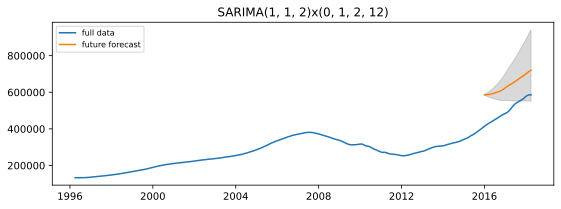

In [124]:
fc1, conf1 = log_model_d1_D1_full.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(np.exp(fc1), index=logtest.index)

lower_series1 = np.exp(pd.Series(conf1[:, 0], index=logtest.index))
upper_series1 = np.exp(pd.Series(conf1[:, 1], index=logtest.index))


# Plot
plt.figure(figsize=(9, 3))
plt.plot(np.exp(logfull), label='full data')
plt.plot(fc_series1, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 2)x(0, 1, 2, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Looping the model

In [125]:
df_seattle = df_main[df_main["City"] == 'Seattle']

In [126]:
df_seattle

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
161,98103,Seattle,WA,Seattle,King,99563,162,1996-04-01,175700.0
331,98115,Seattle,WA,Seattle,King,99575,332,1996-04-01,183400.0
438,98122,Seattle,WA,Seattle,King,99581,439,1996-04-01,168900.0
760,98125,Seattle,WA,Seattle,King,99583,761,1996-04-01,161200.0
963,98109,Seattle,WA,Seattle,King,99569,964,1996-04-01,249000.0
...,...,...,...,...,...,...,...,...,...
3890942,98106,Seattle,WA,Seattle,King,99566,4071,2018-04-01,527400.0
3891104,98126,Seattle,WA,Seattle,King,99584,4233,2018-04-01,641400.0
3891480,98199,Seattle,WA,Seattle,King,99624,4609,2018-04-01,1006600.0
3892308,98108,Seattle,WA,Seattle,King,99568,5437,2018-04-01,584900.0


In [220]:
## I put the best performing model into a loop in order to automatically predict home prices on a series of zipcodes.

def zipSplit(df):
    unique_zip = df.RegionName.unique()
    for code in unique_zip:
        df_temp = df_main[df_main["RegionName"] == code]
        print(code)
        sellprice_temp = df_temp['value']
        sellprice_temp.index = pd.DatetimeIndex(df_temp['time'])
        sellprice_not_na_temp = sellprice_temp[~sellprice_temp.isna()]
    
        train_size_temp = int(len(sellprice_not_na_temp) * 0.80) ### Nix
        train, valid  = sellprice_not_na_temp[:train_size_temp], sellprice_not_na_temp[train_size_temp:]
        test_temp = pd.date_range(start = '2018-05-01', end = '2019-04-01', freq = 'MS')
    
        model_d1_D2_temp = pm.auto_arima(train, start_p=1, start_q=1,
                                    max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                    start_P=0, seasonal=True,
                                    d=1, D=2, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
        
        params_temp = model_d1_D2_temp.get_params()

        fc1, conf1 = model_d1_D2_temp.predict(len(valid), return_conf_int=True, alpha=0.05)
        fc2, conf2 = model_d1_D2_temp.predict(len(test_temp), return_conf_int=True, alpha=0.05)
        fc_series1 = pd.Series(fc1, index=valid.index)
        fc_series2 = pd.Series(fc2 + df_temp['value'].iloc[-1] - valid.iloc[0], index=test_temp)

        lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
        upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
        lower_series2 = pd.Series(conf2[:, 0]+ df_temp['value'].iloc[-1] - valid.iloc[0], index=test_temp)
        upper_series2 = pd.Series(conf2[:, 1]+ df_temp['value'].iloc[-1] - valid.iloc[0], index=test_temp)

        # Plot
        plt.figure(figsize=(9, 3))
        plt.plot(train, label='training')
        plt.plot(valid, label='validation')
        plt.plot(fc_series1, label='validation forecast')
        plt.plot(fc_series2, label='future forecast')

        plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
        plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

        plt.title(f'SARIMA {params_temp["order"]}x{params_temp["seasonal_order"]} ' + str(code))
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
    return print("Done")

98103
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3626.028, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3593.813, Time=1.58 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3606.807, Time=0.39 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3646.545, Time=2.05 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(1,1,0)(0,2,1)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.45 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=3621.645, Time=0.25 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3585.303, Time=2.65 sec
 ARIMA(2,1,0)(0,2,0)[12]             : AIC=3599.856, Time=0.81 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3560.618, Time=5.62 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.42 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=

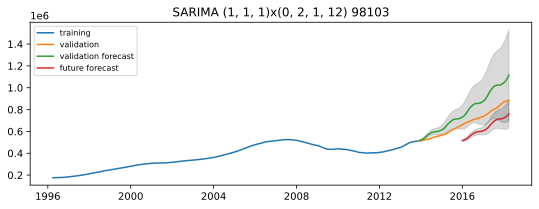

98115
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3593.176, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3568.037, Time=1.59 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3576.542, Time=0.40 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3554.124, Time=3.94 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.83 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3580.642, Time=2.18 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3540.990, Time=5.73 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3558.150, Time=2.75 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.30 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=2.95 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3536.099, Time=7.59 sec
 ARIMA(3,1,0)(1,2,0)[12]             : AIC=

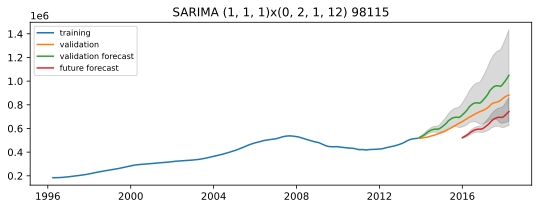

98122
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3608.367, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3580.975, Time=1.61 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3587.897, Time=0.41 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3629.988, Time=1.95 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(1,1,0)(0,2,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=4.52 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=3605.240, Time=0.24 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3574.329, Time=2.55 sec
 ARIMA(2,1,0)(0,2,0)[12]             : AIC=3582.688, Time=0.69 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3556.634, Time=6.02 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.52 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=

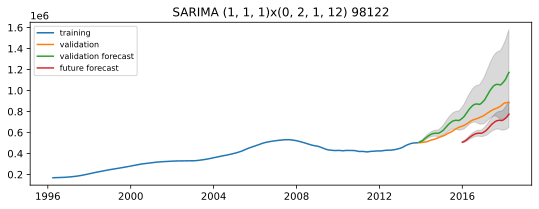

98125
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3576.562, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3538.964, Time=1.63 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3551.145, Time=0.39 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3515.254, Time=4.37 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=4.98 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3558.331, Time=0.70 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3499.348, Time=6.07 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3525.765, Time=2.41 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.43 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,1,1)(2,2,0)[12]             : AIC=3519.4

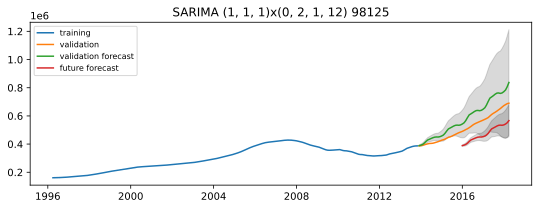

98109
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.20 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3760.402, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3744.064, Time=1.75 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=3753.171, Time=1.01 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3746.707, Time=0.42 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3731.046, Time=4.06 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.83 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3753.569, Time=0.77 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3722.718, Time=6.33 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3738.839, Time=2.79 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=5.83 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3719.841, Time=8.15 sec
 ARIMA(3,1,0)(1,2,0)[12]             :

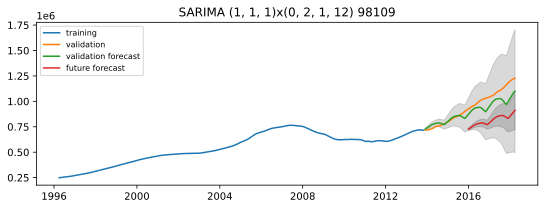

98105
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3632.839, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3621.771, Time=1.56 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3624.364, Time=0.41 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3673.201, Time=2.04 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(1,1,0)(0,2,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.16 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=3631.838, Time=0.25 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3688.354, Time=1.11 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3617.796, Time=2.10 sec
 ARIMA(1,1,1)(0,2,0)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3654.814, Time=2.16 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=

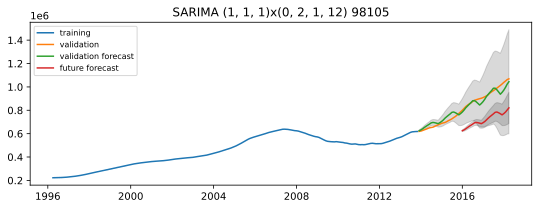

98118
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.60 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.38 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.80 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.17 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.71 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.55 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.25 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.28 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.08 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=

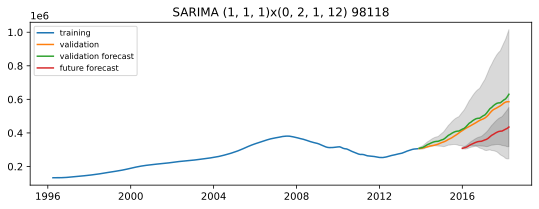

98102
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3878.485, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=4094.640, Time=0.98 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=3890.270, Time=0.24 sec
 ARIMA(0,1,0)(0,2,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(1,2,1)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3855.914, Time=0.38 sec
 ARIMA(1,1,0)(0,2,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(2,1,0)(0,2,0)[12]             : AIC=3844.780, Time=0.92 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3827.045, Time=3.11 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3934.406, Time=3.28 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.58 sec
 ARIMA(2,1,0)(0,2,1)[12]             : AIC=inf, 

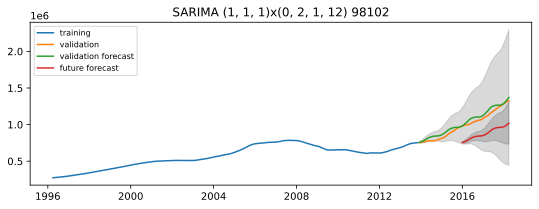

98107
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3682.292, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3630.092, Time=1.73 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3649.134, Time=0.47 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3582.758, Time=4.94 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.48 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3658.991, Time=0.78 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3561.175, Time=6.02 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3609.157, Time=2.80 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=6.94 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.65 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3556.974, Time=7.97 sec
 ARIMA(3,1,0)(1,2,0)[12]             : AIC=

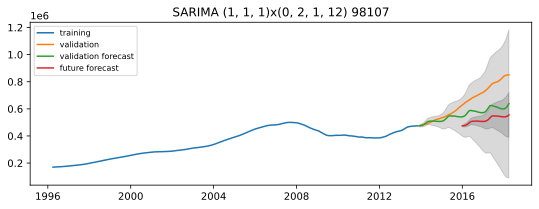

98117
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3654.156, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3602.691, Time=1.82 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3622.003, Time=0.43 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3563.910, Time=4.56 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.93 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.36 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3635.104, Time=1.42 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3537.478, Time=5.82 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3579.707, Time=2.71 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.17 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.80 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3528.017, Time=7.99 sec
 ARIMA(3,1,0)(1,2,0)[12]             : AIC=

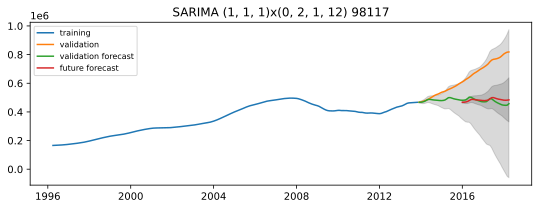

98116
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3702.557, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3659.381, Time=1.95 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3677.094, Time=0.40 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3623.078, Time=4.53 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.89 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3682.763, Time=0.77 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3607.518, Time=6.15 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3646.613, Time=2.65 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.41 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.39 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3604.225, Time=7.42 sec
 ARIMA(3,1,0)(1,2,0)[12]             : AIC=

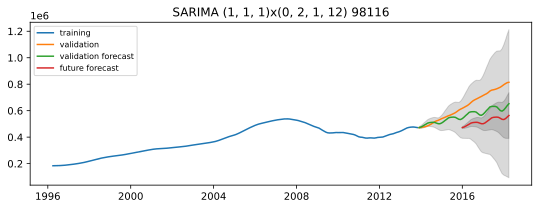

98144
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3639.391, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3576.689, Time=1.89 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3602.044, Time=0.43 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3518.210, Time=4.54 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.47 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3611.232, Time=0.88 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3500.887, Time=6.00 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3557.592, Time=2.50 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.33 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.11 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3501.163, Time=6.86 sec
 ARIMA(2,1,1)(2,2,0)[12]             : AIC=

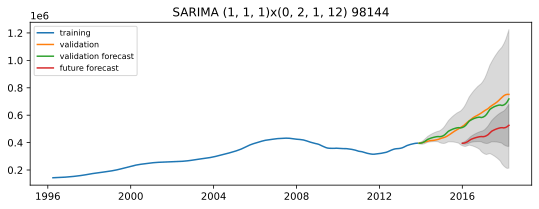

98119
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.29 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3826.947, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3792.087, Time=2.14 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3804.154, Time=0.47 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3965.227, Time=2.34 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(1,1,0)(0,2,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.92 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=3827.627, Time=0.33 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3777.286, Time=3.23 sec
 ARIMA(2,1,0)(0,2,0)[12]             : AIC=3792.406, Time=0.88 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3759.761, Time=6.03 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=6.96 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=

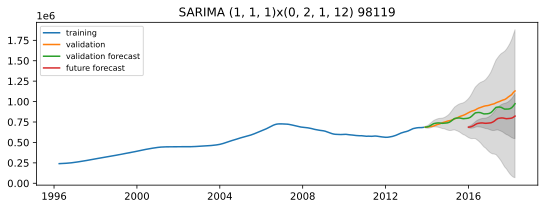

98112
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3886.273, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3856.565, Time=1.92 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3869.157, Time=0.46 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3943.533, Time=2.23 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,2,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=3884.650, Time=0.28 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3847.320, Time=3.13 sec
 ARIMA(2,1,0)(0,2,0)[12]             : AIC=3861.711, Time=0.93 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3927.920, Time=3.48 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(2,1,0)(0,2,1)[12]             : AIC=

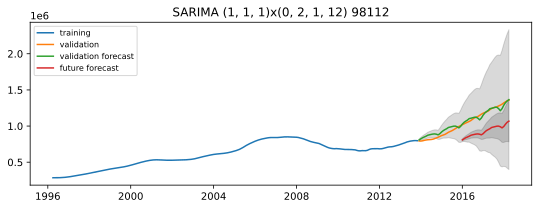

98106
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3558.710, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3492.194, Time=1.49 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3515.135, Time=0.44 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3432.318, Time=4.12 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.14 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3530.181, Time=0.77 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3412.317, Time=5.79 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3469.772, Time=2.75 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.48 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=2.87 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3405.875, Time=6.36 sec
 ARIMA(3,1,0)(1,2,0)[12]             : AIC=

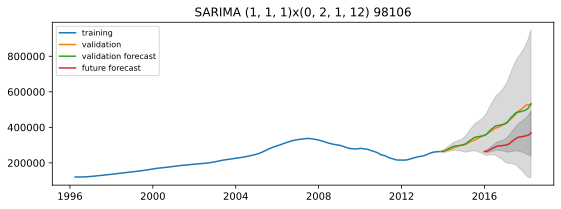

98126
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3567.491, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3528.290, Time=1.83 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3539.522, Time=0.46 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3495.091, Time=3.83 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.24 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.39 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3550.689, Time=0.76 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3471.776, Time=5.84 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3510.221, Time=2.56 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=8.22 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.17 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3464.914, Time=9.67 sec
 ARIMA(3,1,0)(1,2,0)[12]             : AIC=

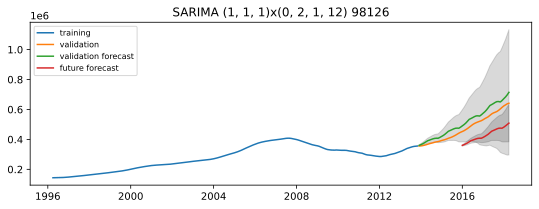

98199
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3839.061, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3801.860, Time=2.20 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3816.726, Time=0.46 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3749.119, Time=4.85 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=6.57 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=3.11 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3820.769, Time=0.83 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3733.419, Time=6.62 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3788.120, Time=3.40 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.33 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=inf, Time=7.89 sec
 ARIMA(2,1,1)(2,2,0)[12]             : AIC=3992.

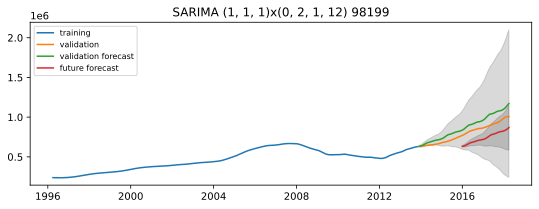

98108
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3544.997, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3498.319, Time=1.56 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3512.894, Time=0.38 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3461.155, Time=3.79 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.34 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3524.489, Time=0.70 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3447.490, Time=5.00 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3485.861, Time=2.20 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=6.84 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=2.66 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3445.096, Time=8.54 sec
 ARIMA(3,1,0)(1,2,0)[12]             : AIC=

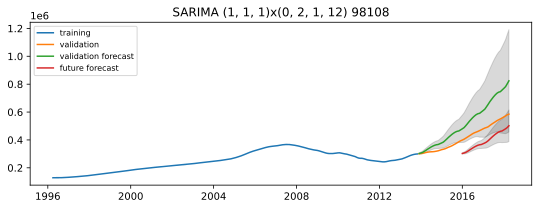

98136
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3725.263, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3668.057, Time=1.83 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3689.575, Time=0.46 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3600.497, Time=4.00 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.76 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3695.706, Time=0.84 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3583.112, Time=6.12 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3646.786, Time=2.85 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=7.64 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.90 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3596.160, Time=8.21 sec
 ARIMA(2,1,1)(2,2,0)[12]             : AIC=

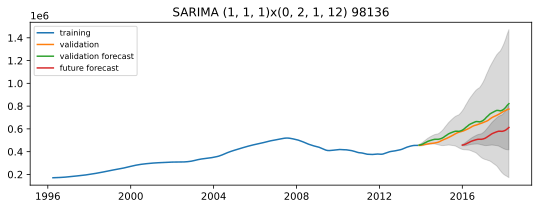

Done


In [62]:
zipSplit(df_seattle)

98118
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.66 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.40 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.93 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.33 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.73 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.64 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.36 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.35 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.29 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=

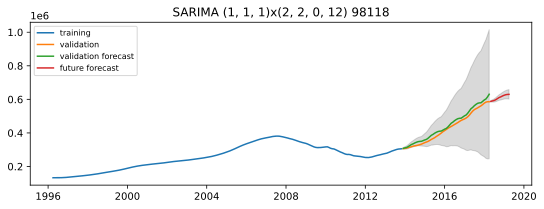

Done


In [229]:
zipSplit(df_cc)

## Top 5 zipcodes

In [ ]:
## I chose the top 5 zip codes first based on model accuracy and second by strongest predicted increase.
University District/laurelhurst 98105
Columbia City 98118
Youngstown 98126
Madison Valley 98112 
Delridge 98106

In [113]:
df_university = df_main[df_main['RegionName'] == 98105]
df_ccity = df_main[df_main['RegionName'] == 98118]
df_young = df_main[df_main['RegionName'] == 98126]
df_madison = df_main[df_main['RegionName'] == 98112]
df_delridge = df_main[df_main['RegionName'] == 98106]

In [115]:
df_top = pd.concat([df_university, df_ccity, df_young, df_madison, df_delridge])

In [226]:
## This is a new function designed to predict 2 years of home values using the same models trained on all relevant data.
def zipPredict(df):
    unique_zip = df.RegionName.unique()
    for code in unique_zip:
        df_temp = df_main[df_main["RegionName"] == code]
        print(code)
        sellprice_temp = df_temp['value']
        sellprice_temp.index = pd.DatetimeIndex(df_temp['time'])
        sellprice_not_na_temp = sellprice_temp[~sellprice_temp.isna()]
    
        train_size_temp = int(len(sellprice_not_na_temp))
        test_temp = pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')
    
        model_d1_D2_temp = pm.auto_arima(train, start_p=1, start_q=1,
                                    max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                    start_P=0, seasonal=True,
                                    d=1, D=2, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
        
        params_temp = model_d1_D2_temp.get_params()

        fc2, conf2 = model_d1_D2_temp.predict(len(test_temp), return_conf_int=True, alpha=0.05)
        fc_series2 = pd.Series(fc2 + df_temp['value'].iloc[-1] - valid.iloc[0], index=test_temp)

        lower_series2 = pd.Series(conf2[:, 0]+ df_temp['value'].iloc[-1] - valid.iloc[0], index=test_temp)
        upper_series2 = pd.Series(conf2[:, 1]+ df_temp['value'].iloc[-1] - valid.iloc[0], index=test_temp)

        # Plot
        plt.figure(figsize=(9, 3))
        plt.plot(sellprice_temp, label='training')
        plt.plot(fc_series2, label='future forecast')

        plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

        plt.title(f'SARIMA {params_temp["order"]}x{params_temp["seasonal_order"]} ' + str(code))
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
    return print("Done")

98105
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.64 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.39 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.87 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.22 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.71 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.58 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.25 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.31 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.11 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=

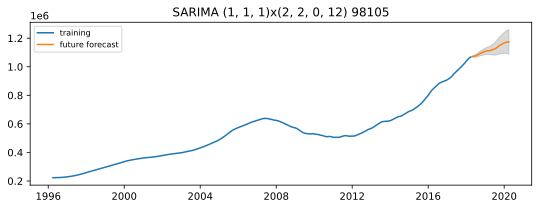

98118
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.62 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.39 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.86 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.22 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.72 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.65 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.28 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.31 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.19 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=

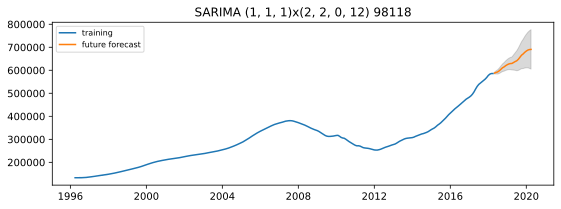

98126
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.63 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.39 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.87 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.22 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.71 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.56 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.28 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.30 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.11 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=

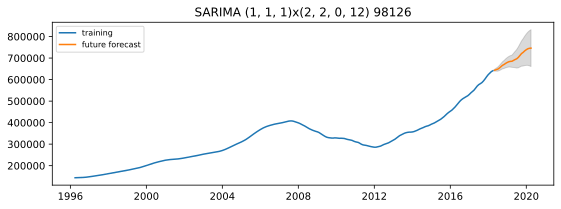

98112
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.63 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.39 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.89 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.20 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.72 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.58 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.25 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.29 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.10 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=

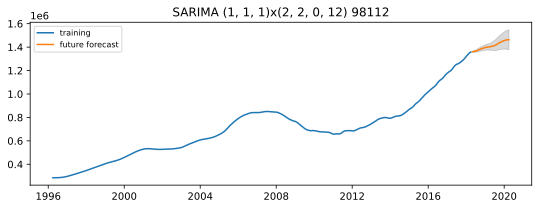

98106
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.06 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.67 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.40 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.90 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.22 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.71 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.57 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.42 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.36 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.17 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=

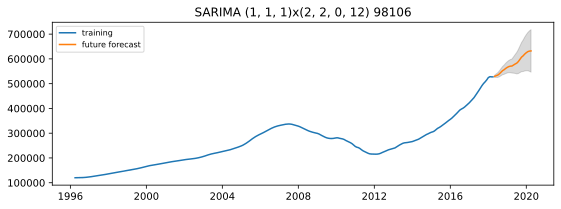

Done


In [227]:
zipPredict(df_top)

# In Conclusion

Seattle has been a hot and incredibly growing market since 2012. While property prices are currently high the trends show
that an investment there will most likely see a great return in future equity. These 5 neighborhoods in particular exhibit
a great deal of promise.

University District/Laurelhurst

Columbia City

West Seattle

Delridge

Madison Valley
